## Notebook to train PLSR model for CE prediction using graph embeddings (LUMO-pretrained model)

### Graph embeddings size = 200

**Split: stratified split-2 + stratified CV**

**Output units: common log**

**Created on 16th December, 2023; modified on 17th January, 2024**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Arial'
from matplotlib import colors as mcolors
import matplotlib
from matplotlib.offsetbox import AnchoredText
import seaborn as sns
import os
import sys
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix, r2_score, mean_squared_error, mean_absolute_error
import glob
from sklearn.model_selection import KFold, StratifiedKFold, GridSearchCV, cross_val_score, RandomizedSearchCV
import pickle

In [2]:
%%bash
pwd
ls -ltr

/Users/riteshk/Library/CloudStorage/Box-Box/Research-postdoc/liquid-electrolyte-ML/Science-rev-1/coulombic-efficiency_1.1/using-pretrainedGR/gr-embed-200/common-log-output/random-split
total 3424
-rw-r--r--@ 1 riteshk  staff  526649 Jan 17 15:10 plsr_CE_prediction_gr.ipynb
-rw-r--r--  1 riteshk  staff  126875 Jan 17 15:41 rand_test_gr_comb_add.csv
-rw-r--r--  1 riteshk  staff  907872 Jan 17 15:41 rand_train_gr_comb_add.csv
-rw-r--r--  1 riteshk  staff  118863 Jan 17 15:41 rand_val_gr_comb_add.csv
-rw-r--r--@ 1 riteshk  staff   62973 Feb  4 16:41 CE_prediction_plsr_graph_embed_feat_random_ood_parity_plot.ipynb


In [3]:
def plot_parity(y_true, y_pred, y_pred_unc=None, figname=None):
    plt.clf()
    
    axmin = min(min(y_true), min(y_pred)) - 0.1*(max(y_true)-min(y_true))
    axmax = max(max(y_true), max(y_pred)) + 0.1*(max(y_true)-min(y_true))
    
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    
    plt.plot([axmin, axmax], [axmin, axmax], '--k')
    
    plt.errorbar(y_true, y_pred, yerr=y_pred_unc, linewidth=0, marker='o', markeredgecolor='w', alpha=1, elinewidth=1, color='blue', markersize=8)
    
    plt.xlim((axmin, axmax))
    plt.ylim((axmin, axmax))
    
    ax = plt.gca()
    ax.set_aspect('equal')
    
    at = AnchoredText(
    f"MAE = {mae:.2f}\nRMSE = {rmse:.2f}\nR$^2$ = {r2:.2f}", prop=dict(size=10), frameon=True, loc='upper left')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(at)
    
    plt.xlabel('True log$_{10}{}$CI')
    plt.ylabel('ML-predicted log$_{10}{}$CI')
    if figname != None:
        plt.savefig(figname, dpi=150)
    else:
        plt.show()
        
    ax.clear()
    return

In [4]:
df_train = pd.read_csv('./rand_train_gr_comb_add.csv')
df_val = pd.read_csv('./rand_val_gr_comb_add.csv')
df_test = pd.read_csv('./rand_test_gr_comb_add.csv')
df_ood = pd.read_csv('./ce_ood_final_comp.csv')

In [6]:
df_train

,solv_smile_comb,salt_smile_comb,solv_fp_0_mol_0,solv_fp_1_mol_0,solv_fp_2_mol_0,solv_fp_3_mol_0,solv_fp_4_mol_0,solv_fp_5_mol_0,solv_fp_6_mol_0,solv_fp_7_mol_0,...,solv_ratio_2,solv_ratio_3,mw_salt_1,mw_salt_2,salt_1_conc,salt_2_conc,mw_add,protocol,current_density,log(1-CE)
0,O=C1OCCO1.COC(=O)OC.COCCOCCOCCOCCOC,F[P-](F)(F)(F)(F)F.[Li+].O=[N+]([O-])[O-].[Li+],0.028599,0.031528,-0.013138,0.034162,-0.008458,-0.006427,-0.009211,0.015324,...,0.600000,0.2,151.980186,0.000000,1.0,0.0,69.003822,1,2.0,-1.698970
1,COC(=O)OC,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.008580,-0.008070,-0.013210,-0.009722,-0.010997,-0.007725,-0.011858,-0.004951,...,0.000000,0.0,186.939685,0.000000,1.2,0.0,0.000000,1,0.5,-0.040959
2,COCCOCCOCCOCCOC,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+].O=C1OCCO1,-0.005206,0.013194,-0.012076,-0.008618,-0.006324,-0.005831,-0.007005,0.032790,...,0.000000,0.0,186.939685,0.000000,3.0,0.0,88.016044,1,0.4,-1.568636
3,O=C1OCCO1.COC(=O)OC,F[P-](F)(F)(F)(F)F.[Li+],0.070854,0.054446,-0.014466,0.087637,-0.011126,-0.007172,-0.011968,-0.006509,...,0.500000,0.0,151.980186,0.000000,1.0,0.0,0.000000,1,0.6,-1.366532
4,COCCOC,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+].O=S(=O)([N-]S(=...,-0.005390,-0.004935,-0.011686,-0.010327,-0.004394,-0.005828,-0.007275,0.091065,...,0.000000,0.0,186.939685,286.933298,4.0,2.0,0.000000,1,0.5,-1.080922
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108,O=C1OCCO1.CCOC(=O)OCC,F[P-](F)(F)(F)(F)F.[Li+].O=C1OCC(F)O1,0.069424,0.046331,-0.015139,0.083333,-0.011125,-0.007302,-0.011989,-0.007036,...,0.500000,0.0,151.980186,0.000000,1.0,0.0,106.006622,3,0.5,-1.301030
109,CC1COC(=O)O1,[Li+].[O-][Cl+3]([O-])([O-])[O-].O=S=O,0.130691,0.050793,-0.015092,0.162493,0.007925,-0.006418,-0.010257,-0.007271,...,0.000000,0.0,105.964516,0.000000,1.0,0.0,63.961900,1,5.0,-0.785156
110,CCOCCOCC,O=S(=O)(F)[N-]S(=O)(=O)F.[Li+],-0.006364,0.055103,-0.013114,-0.009644,-0.006275,-0.006170,-0.007244,-0.003442,...,0.000000,0.0,186.939685,0.000000,1.2,0.0,0.000000,-1,0.5,-2.000000
111,COC(=O)CC(F)(F)F.O=C1OCC(F)O1,F[P-](F)(F)(F)(F)F.[Li+],0.218118,0.012724,-0.010560,0.073425,-0.011996,0.002649,-0.000737,0.001076,...,0.090909,0.0,151.980186,0.000000,1.0,0.0,0.000000,2,0.5,-1.619789


In [14]:
print(df_train['log(1-CE)'].max())
print(df_train['log(1-CE)'].min())

-0.0409586074742489
-3.221848749725743


*********Number of components: 5***********
0.47481643364949233
RMSE train: 0.3584197666382874 & RMSE val: 0.42483929254144615 & RMSE test: 0.46991092956058006
R2 train: 0.620723027964508 & R2 val: 0.2631129488206986 & R2 test: 0.39133751064091593
MAE train: 0.27534575651397436 & MAE val: 0.34351737049889447 & MAE test: 0.34654133604370213
Avg RMSE ood: 0.40655794454356187, Avg MAE ood: 0.32811060478481513, Avg R2 ood: 0.03303582417883211
*********Number of components: 6***********
0.4559310246073192
RMSE train: 0.32899372393067067 & RMSE val: 0.4066249490500305 & RMSE test: 0.4455617109931601
R2 train: 0.6804433968399943 & R2 val: 0.32494429043616 & R2 test: 0.4527809960175122
MAE train: 0.2540107466389967 & MAE val: 0.3260886002453764 & MAE test: 0.3314279482394987
Avg RMSE ood: 0.40490678134375996, Avg MAE ood: 0.32529619872558974, Avg R2 ood: 0.0408741827593786
*********Number of components: 7***********
0.44402015393484257
RMSE train: 0.3101601136362961 & RMSE val: 0.4427431340454

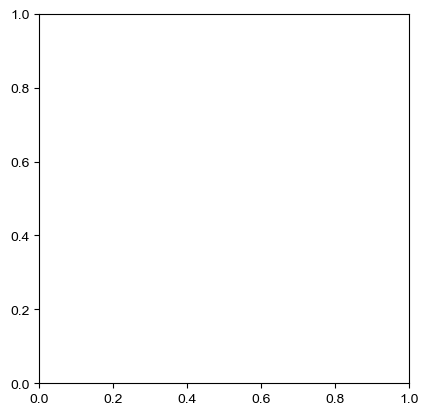

In [13]:
X_train = df_train.iloc[:, 2:-1]  # Assuming first two columns are descriptions
y_train = df_train.iloc[:, -1].values
X_val = df_val.iloc[:, 2:-1]
y_val = df_val.iloc[:, -1].values
X_test = df_test.iloc[:, 2:-1]
y_test = df_test.iloc[:, -1].values
X_ood = df_ood.iloc[:, 2:-1]
y_ood = df_ood.iloc[:, -1].values

## scaling the data
scaler = MinMaxScaler().fit(X_train.iloc[:,-13:])
X_train_scaled = scaler.transform(X_train.iloc[:,-13:])
X_train_ = np.concatenate((X_train.iloc[:,:-13], X_train_scaled), axis=1)
X_val_scaled = scaler.transform(X_val.iloc[:,-13:])
X_val_ = np.concatenate((X_val.iloc[:,:-13], X_val_scaled), axis=1)
X_test_scaled = scaler.transform(X_test.iloc[:,-13:])
X_test_ = np.concatenate((X_test.iloc[:,:-13], X_test_scaled), axis=1)
X_ood_scaled = scaler.transform(X_ood.iloc[:,-13:])
X_ood_ = np.concatenate((X_ood.iloc[:,:-13], X_ood_scaled), axis=1)

## run only once!!
r2_train_fin = []; rmse_train_fin = []; mae_train_fin = []
r2_val_fin = []; rmse_val_fin = []; mae_val_fin = []
r2_test_fin = []; rmse_test_fin = []; mae_test_fin = []
r2_ood_fin = []; rmse_ood_fin = []; mae_ood_fin = []
comp_fin = []

for comp in range(5, 13):
    print(f"*********Number of components: {comp}***********")
    ncomp = comp
    # ncomp = 11

    ## optimize over random states of KFold
    rmse_cv_array = []
    for i in range(0,100):
        # print(f"Step {i}")
        # Initialize KFold cross-validation
        kf = KFold(n_splits=5, shuffle=True, random_state=i)
        plsr = PLSRegression(n_components=ncomp, scale=False)
        # plsr = PLSRegression(n_components=ncomp, scale=True) ## don't use scale=True

        fold = 1
        # Loop over each fold
        rmse_val = []; rmse_train = []
        for train_index, val_index in kf.split(X_train_):
            # print("Fold {}".format(fold))
            # Split the data
            X_train_fold, X_val_fold = X_train_[train_index], X_train_[val_index]
            y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

            # Fit the model on the training data
            plsr.fit(X_train_fold, y_train_fold)

            y_pred_val_fold = plsr.predict(X_val_fold)
            r2 = r2_score(y_val_fold, y_pred_val_fold); rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred_val_fold)); mae = mean_absolute_error(y_val_fold, y_pred_val_fold)
            # print(f"Train set CV, R2 score: {r2}, RMSE: {rmse}, MAE: {mae}")
            rmse_train.append(rmse)

            ## predict on validation test
            y_pred_val = plsr.predict(X_val_)
            r2 = r2_score(y_val, y_pred_val); rmse = np.sqrt(mean_squared_error(y_val, y_pred_val)); mae = mean_absolute_error(y_val, y_pred_val)
            # print(f"Validation set, R2 score: {r2}, RMSE: {rmse}, MAE: {mae}")
            rmse_val.append(rmse)

            fold += 1
        # print(f"RMSE train: {np.mean(rmse_train)} & RMSE val: {np.mean(rmse_val)}")
        rmse_cv_array.append(np.mean(rmse_train))

    ind = min(range(len(rmse_cv_array)), key=rmse_cv_array.__getitem__)
    print(rmse_cv_array[ind])

    ## use the best random state to train the model
    kf = KFold(n_splits=5, shuffle=True, random_state=ind)

    plsr = PLSRegression(n_components=ncomp, scale=False)

    fold = 1
    # Loop over each fold
    pred_train_array = []; pred_val_array = []; pred_test_array = []
    for train_index, val_index in kf.split(X_train_):
        X_train_fold, X_val_fold = X_train_[train_index], X_train_[val_index]
        y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

        # Fit the model on the training data
        plsr.fit(X_train_fold, y_train_fold)

        # Store the model
        # models.append(plsr)
        y_pred_val_fold = plsr.predict(X_val_fold)
        r2 = r2_score(y_val_fold, y_pred_val_fold); rmse = np.sqrt(mean_squared_error(y_val_fold, y_pred_val_fold)); mae = mean_absolute_error(y_val_fold, y_pred_val_fold)
        
        y_pred_train = plsr.predict(X_train_)
        pred_train_array.append(y_pred_train)

        ## predict on validation test
        y_pred_val = plsr.predict(X_val_)
        pred_val_array.append(y_pred_val)

        # ## predict on test set
        y_pred_test = plsr.predict(X_test_)
        pred_test_array.append(y_pred_test)

        ## save plsr model to pickle
        filename = f'./plsr_model_random_ncomp_{ncomp}_fold_{fold}.sav'
        pickle.dump(plsr, open(filename, 'wb'))
        fold += 1

    ## calculate the average of the predictions on train, val and test
    y_pred_train_avg = np.mean(pred_train_array, axis=0); y_pred_val_avg = np.mean(pred_val_array, axis=0); y_pred_test_avg = np.mean(pred_test_array, axis=0)
    r2_train = r2_score(y_train, y_pred_train_avg); rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train_avg)); mae_train = mean_absolute_error(y_train, y_pred_train_avg)
    r2_val = r2_score(y_val, y_pred_val_avg); rmse_val = np.sqrt(mean_squared_error(y_val, y_pred_val_avg)); mae_val = mean_absolute_error(y_val, y_pred_val_avg)
    r2_test = r2_score(y_test, y_pred_test_avg); rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test_avg)); mae_test = mean_absolute_error(y_test, y_pred_test_avg)
    print(f"RMSE train: {rmse_train} & RMSE val: {rmse_val} & RMSE test: {rmse_test}")
    print(f"R2 train: {r2_train} & R2 val: {r2_val} & R2 test: {r2_test}")
    print(f"MAE train: {mae_train} & MAE val: {mae_val} & MAE test: {mae_test}")

    ## predict on ood & save parity plot
    pred_array = []
    # r2_ood = []; rmse_ood = []; mae_ood = []
    for i in range(1,6):
        filename = f'./plsr_model_random_ncomp_{ncomp}_fold_{i}.sav'
        loaded_model = pickle.load(open(filename, 'rb'))
        y_pred_ood = loaded_model.predict(X_ood_)
        pred_array.append(y_pred_ood)
        # r2 = r2_score(y_ood_, y_pred_ood); rmse = np.sqrt(mean_squared_error(y_ood_red, y_pred_ood)); mae = mean_absolute_error(y_ood_red, y_pred_ood)
        # r2_ood.append(r2); rmse_ood.append(rmse); mae_ood.append(mae)
        # print(f"Fold {i}, R2 score: {r2}, RMSE: {rmse}, MAE: {mae}")

    # y_l = x_l = np.linspace(-6, -0.5, 100)
    y_pred_ood_avg = np.mean(pred_array, axis=0)
    y_pred_ood_avg = np.ravel(y_pred_ood_avg)
    y_pred_ood_std = np.std(pred_array, axis=0)
    y_pred_ood_std = np.ravel(y_pred_ood_std)
    rmse_ood = np.sqrt(mean_squared_error(y_ood, y_pred_ood_avg)); mae_ood = mean_absolute_error(y_ood, y_pred_ood_avg); r2_ood = r2_score(y_ood, y_pred_ood_avg)
    print(f"Avg RMSE ood: {rmse_ood}, Avg MAE ood: {mae_ood}, Avg R2 ood: {r2_ood}")

    plot_parity(y_ood, y_pred_ood_avg, y_pred_ood_std, figname='./plsr_random_ood_comp{}.png'.format(ncomp))

    r2_train_fin.append(r2_train); rmse_train_fin.append(rmse_train); mae_train_fin.append(mae_train)
    r2_val_fin.append(r2_val); rmse_val_fin.append(rmse_val); mae_val_fin.append(mae_val)
    r2_test_fin.append(r2_test); rmse_test_fin.append(rmse_test); mae_test_fin.append(mae_test)
    r2_ood_fin.append(r2_ood); rmse_ood_fin.append(rmse_ood); mae_ood_fin.append(mae_ood)
    comp_fin.append(ncomp)

score_df = pd.DataFrame({'Components': comp_fin, 'R2_train': r2_train_fin, 'RMSE_train': rmse_train_fin, 'MAE_train': mae_train_fin, 'R2_val': r2_val_fin, 'RMSE_val': rmse_val_fin, 'MAE_val': mae_val_fin, 'R2_test': r2_test_fin, 'RMSE_test': rmse_test_fin, 'MAE_test': mae_test_fin, 'R2_ood': r2_ood_fin, 'RMSE_ood': rmse_ood_fin, 'MAE_ood': mae_ood_fin})
score_df.to_csv('./plsr_cv_scores_random.csv', index=False)
# seed_perf_df = pd.concat([seed_perf_df, score_df], axis=0, ignore_index=True)